In [1]:
import tweepy as tw
import json
import os
import pandas as pd
import time
import seaborn as sns
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from matplotlib.pyplot import figure
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
bearer_token= 'AAAAAAAAAAAAAAAAAAAAALf6cgEAAAAAnhNw6UbghMq%2BbAsgLQZhqkz0c6s%3D0shGuCMEVBBDwNJeGRzXUkmXXjsz4OCbv86w7qxdBYgcghsrXI'

In [3]:
client = tw.Client(bearer_token, wait_on_rate_limit= True)

In [4]:
PicoYPlaca_tweets=[]
for response in tw.Paginator(client.search_all_tweets, 
                                 query = '"Pico y Placa Regional" OR #PicoYPlacaRegional  lang:es',
                                 user_fields = ['username', 'public_metrics', 'description', 'location'],
                                 tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2022-01-07T00:00:00Z',
                                 end_time = '2022-05-20T23:59:00Z',
                                 max_results=500):
    time.sleep(1)
    PicoYPlaca_tweets.append(response)

In [5]:
PicoYPlaca_tweets

[Response(data=[<Tweet id=1527288912166563842 text='"Desde @SectorMovilidad trabajamos para que la movilidad sea más ágil y amigable a través de:\n\n-Transporte férreo\n-Movilidad en bici\n-Mejoramiento de los accesos a Bogotá\n-Tansporte público eléctrico\n-Movilidad compartida\n-Pico y Placa Regional"\n\n@ForosSemana #AsíSeMueveColombia https://t.co/601v3Ihm8Y'>, <Tweet id=1525262154336714755 text='@AlcMosquera @GeromettaGian ¿Y mientras tanto en estos 5 o 6 años que durará ese proyecto en entrar a funcionar, que hacemos?  \n\nEl Pico y placa regional para el transporte de los corredores calle 13-variante funza-mosquera y calle 80 ¿para cuando?'>, <Tweet id=1523021252646301696 text='@SectorMovilidad hola! Mañana hay pico y placa regional para ingresar a Bogotá?'>, <Tweet id=1523020642039349248 text='@numeral767 hola! Me podrían informar por favor, si mañana hay pico y placa regional para entrar a Bogotá?'>, <Tweet id=1520802984388608002 text='Hoy hay pico y placa regional para entrar

In [6]:
result = []
user_dict = {}
# Loop through each response object
for response in PicoYPlaca_tweets:
    # Take all of the users, and put them into a dictionary  with the info we want to keep
    for user in response.includes['users']:
        user_dict[user.id] = {'username': user.username, 
                              'followers': user.public_metrics['followers_count'],
                              'tweets': user.public_metrics['tweet_count'],
                              'description': user.description,
                              'location': user.location
                             }
    for tweet in response.data:
        # For each tweet, find the author's information
        author_info = user_dict[tweet.author_id]
        # Put all of the information we want to keep in a single dictionary for each tweet
        result.append({'author_id': tweet.author_id, 
                       'username': author_info['username'],
                       'author_followers': author_info['followers'],
                       'author_tweets': author_info['tweets'],
                       'author_description': author_info['description'],
                       'author_location': author_info['location'],
                       'text': tweet.text,
                       'created_at': tweet.created_at,
                       'retweets': tweet.public_metrics['retweet_count'],
                       'replies': tweet.public_metrics['reply_count'],
                       'likes': tweet.public_metrics['like_count'],
                       'quote_count': tweet.public_metrics['quote_count']
                      })

# Change this list of dictionaries into a dataframe
df = pd.DataFrame(result)

In [7]:
df.head(-5)

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,119431745,SectorMovilidad,1507519,155812,Información oficial de la Secretaría de Movili...,"Bogotá, Colombia","""Desde @SectorMovilidad trabajamos para que la...",2022-05-19 14:03:46+00:00,0,3,0,0
1,1242513283409760256,jhonfredypesca1,2,5,,None,@AlcMosquera @GeromettaGian ¿Y mientras tanto ...,2022-05-13 23:50:10+00:00,0,0,1,0
2,322771063,julireyesrojas7,44,835,,None,@SectorMovilidad hola! Mañana hay pico y placa...,2022-05-07 19:25:37+00:00,0,0,0,0
3,322771063,julireyesrojas7,44,835,,None,@numeral767 hola! Me podrían informar por favo...,2022-05-07 19:23:12+00:00,0,1,0,0
4,23910809,Sebastianbitar,4841,7287,"Profesor @GobiernoUandes. Asuntos Globales, ar...","Bogotá, D.C., Colombia",Hoy hay pico y placa regional para entrar a Bo...,2022-05-01 16:31:01+00:00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3594,119431745,SectorMovilidad,1507519,155812,Información oficial de la Secretaría de Movili...,"Bogotá, Colombia",Desde los peajes y diferentes vías de la ciuda...,2022-01-07 18:45:00+00:00,23,36,55,7
3595,252134272,CanalCapital,616674,563073,"Somos Capital, sistema de comunicación pública...","Bogotá, Colombia",RT @capitalahora: ⭕ #ENVIVO \n\n#NoticiasCapit...,2022-01-07 17:24:09+00:00,1,0,0,0
3596,1392848900197916678,capitalahora,549,6269,El principal medio de actualidad de Bogotá | S...,"Bogotá, D.C., Colombia",⭕ #ENVIVO \n\n#NoticiasCapital | Un millón tre...,2022-01-07 17:22:42+00:00,1,1,1,0
3597,1327641979950391296,AstridSaldaa10,94,33040,"soy sincera, franca y alegre.",None,"RT @SectorMovilidad: Hoy, desde los centros co...",2022-01-07 17:17:37+00:00,2,0,0,0


In [9]:
df.to_csv('picoyplacaregional_EDA.csv')

# Analyzing Text Statistics

In [10]:
pyp= pd.read_csv('picoyplacaregional_EDA.csv')

In [11]:
pyp.head(5)

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,0,119431745,SectorMovilidad,1507519,155812,Información oficial de la Secretaría de Movili...,"Bogotá, Colombia","""Desde @SectorMovilidad trabajamos para que la...",2022-05-19 14:03:46+00:00,0,3,0,0
1,1,1242513283409760256,jhonfredypesca1,2,5,NaN,NaN,@AlcMosquera @GeromettaGian ¿Y mientras tanto ...,2022-05-13 23:50:10+00:00,0,0,1,0
2,2,322771063,julireyesrojas7,44,835,NaN,NaN,@SectorMovilidad hola! Mañana hay pico y placa...,2022-05-07 19:25:37+00:00,0,0,0,0
3,3,322771063,julireyesrojas7,44,835,NaN,NaN,@numeral767 hola! Me podrían informar por favo...,2022-05-07 19:23:12+00:00,0,1,0,0
4,4,23910809,Sebastianbitar,4841,7287,"Profesor @GobiernoUandes. Asuntos Globales, ar...","Bogotá, D.C., Colombia",Hoy hay pico y placa regional para entrar a Bo...,2022-05-01 16:31:01+00:00,0,1,0,0


In [12]:
pd.set_option('display.max_rows', None)
print("Shape of data=>",pyp.shape)

Shape of data=> (3604, 13)


In [13]:
len(pyp['username'].unique())

1534

In [14]:
pyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3604 entries, 0 to 3603
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          3604 non-null   int64 
 1   author_id           3604 non-null   int64 
 2   username            3604 non-null   object
 3   author_followers    3604 non-null   int64 
 4   author_tweets       3604 non-null   int64 
 5   author_description  3048 non-null   object
 6   author_location     2830 non-null   object
 7   text                3604 non-null   object
 8   created_at          3604 non-null   object
 9   retweets            3604 non-null   int64 
 10  replies             3604 non-null   int64 
 11  likes               3604 non-null   int64 
 12  quote_count         3604 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 366.2+ KB


In [15]:
pyp.isnull().sum()

Unnamed: 0              0
author_id               0
username                0
author_followers        0
author_tweets           0
author_description    556
author_location       774
text                    0
created_at              0
retweets                0
replies                 0
likes                   0
quote_count             0
dtype: int64

In [20]:
pd.set_option('display.max_rows', None)
df.groupby('retweets')['username'].count()

retweets
0      822
1      489
2      327
3      276
4      187
5      130
6      112
7       86
8       42
9       59
10      52
11      56
12      13
13      40
14      13
15      73
16      17
17      17
18      37
19      38
21      22
23      91
25      25
29      59
34      33
35      35
39      39
48      92
64      62
66      66
84      81
118    113
Name: username, dtype: int64

In [61]:
pyp['username'].unique()

array(['SectorMovilidad', 'jhonfredypesca1', 'julireyesrojas7', ...,
       'HardTimesP_more', 'ALEJAND82065094', 'juanfelipezaji'],
      dtype=object)

In [16]:
pyp['text'].unique()

array(['"Desde @SectorMovilidad trabajamos para que la movilidad sea más ágil y amigable a través de:\n\n-Transporte férreo\n-Movilidad en bici\n-Mejoramiento de los accesos a Bogotá\n-Tansporte público eléctrico\n-Movilidad compartida\n-Pico y Placa Regional"\n\n@ForosSemana #AsíSeMueveColombia https://t.co/601v3Ihm8Y',
       '@AlcMosquera @GeromettaGian ¿Y mientras tanto en estos 5 o 6 años que durará ese proyecto en entrar a funcionar, que hacemos?  \n\nEl Pico y placa regional para el transporte de los corredores calle 13-variante funza-mosquera y calle 80 ¿para cuando?',
       '@SectorMovilidad hola! Mañana hay pico y placa regional para ingresar a Bogotá?',
       ...,
       'Hoy, desde los centros comerciales nuestro equipo de pedagogía informa a los ciudadanos el nuevo horario de #PicoYPlaca.\n➡️ Recuerda que será de Lunes a Viernes de 6️⃣ a.m a 9️⃣ p.m y los Lunes Festivos habrá Pico y Placa Regional en los corredores de ingreso a la ciudad. https://t.co/Yrr5NxYWuU',
      

In [17]:
#All tweets in lowercase
pyp['lower']=pyp['text'].apply(lambda x: x.lower())

In [18]:
pyp.head(5)

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,lower
0,0,119431745,SectorMovilidad,1507521,155812,Información oficial de la Secretaría de Movili...,"Bogotá, Colombia","""Desde @SectorMovilidad trabajamos para que la...",2022-05-19 14:03:46+00:00,0,3,0,0,"""desde @sectormovilidad trabajamos para que la..."
1,1,1242513283409760256,jhonfredypesca1,2,5,NaN,NaN,@AlcMosquera @GeromettaGian ¿Y mientras tanto ...,2022-05-13 23:50:10+00:00,0,0,1,0,@alcmosquera @geromettagian ¿y mientras tanto ...
2,2,322771063,julireyesrojas7,44,835,NaN,NaN,@SectorMovilidad hola! Mañana hay pico y placa...,2022-05-07 19:25:37+00:00,0,0,0,0,@sectormovilidad hola! mañana hay pico y placa...
3,3,322771063,julireyesrojas7,44,835,NaN,NaN,@numeral767 hola! Me podrían informar por favo...,2022-05-07 19:23:12+00:00,0,1,0,0,@numeral767 hola! me podrían informar por favo...
4,4,23910809,Sebastianbitar,4841,7287,"Profesor @GobiernoUandes. Asuntos Globales, ar...","Bogotá, D.C., Colombia",Hoy hay pico y placa regional para entrar a Bo...,2022-05-01 16:31:01+00:00,0,1,0,0,hoy hay pico y placa regional para entrar a bo...


In [19]:
pyp['lower'] = pyp['lower'].apply(lambda x: re.sub('[¡!@#$:).;,¿?&]', '', x.lower()))


In [20]:
def clean_text(text):
    text= re.sub(r'rt[\s]+','', text)
    text= re.sub(r'https?:\/\/?[A-Za-z0-9]','', text)
    return text

In [21]:
pyp['lower']=pyp['lower'].apply(clean_text)

In [22]:
pyp['lower'].head()

0    "desde sectormovilidad trabajamos para que la ...
1    alcmosquera geromettagian y mientras tanto en ...
2    sectormovilidad hola mañana hay pico y placa r...
3    numeral767 hola me podrían informar por favor ...
4    hoy hay pico y placa regional para entrar a bo...
Name: lower, dtype: object

# Characters per tweet histogram


<AxesSubplot:>

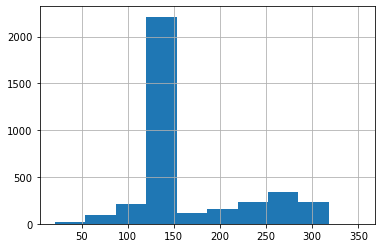

In [23]:
length_tweets= pyp.lower.str.len()
length_tweets.hist()

In [24]:
#Finding the tweetwith max length
max(length_tweets)

351

In [25]:
#Finding the twee twith min length
min(length_tweets)

21

# Words per tweet histogram

<AxesSubplot:>

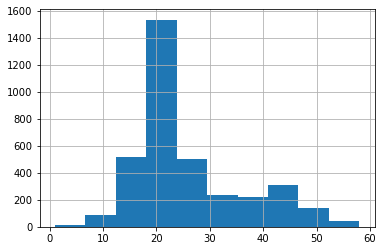

In [26]:
pyp['lower'].str.split().map(lambda x: len(x)).hist()

# Average word length

<AxesSubplot:>

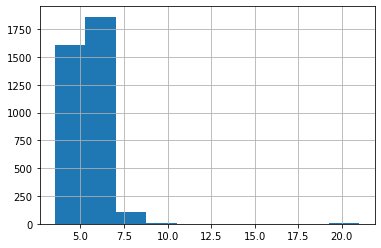

In [27]:
pyp['lower'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

The average word length ranges between 2 to 11 with 5 being the most common length

# StopWords in Spanish

In [28]:
stops_es = set(stopwords.words('spanish'))

In [29]:
my_stop_words = stops_es.union(['pm','com','rt','https://t.co/','@','co','tco','4','https','https:', 'http','t', 'RT','La', 'a.m', 'p.m', 'p.m.', 'a.m.', 'am','pm','p m', '12', '8'])
my_stop_words

{'12',
 '4',
 '8',
 '@',
 'La',
 'RT',
 'a',
 'a.m',
 'a.m.',
 'al',
 'algo',
 'algunas',
 'algunos',
 'am',
 'ante',
 'antes',
 'co',
 'com',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'es

In [30]:
def convert(set):
    return sorted(set)

In [31]:
my_stop_words_sp=convert(my_stop_words)

In [32]:
lista=[]
new= pyp['lower'].str.split()
new=new.values.tolist()
lista=[word for i in new for word in i]




In [33]:
lista

['"desde',
 'sectormovilidad',
 'trabajamos',
 'para',
 'que',
 'la',
 'movilidad',
 'sea',
 'más',
 'ágil',
 'y',
 'amigable',
 'a',
 'través',
 'de',
 '-transporte',
 'férreo',
 '-movilidad',
 'en',
 'bici',
 '-mejoramiento',
 'de',
 'los',
 'accesos',
 'a',
 'bogotá',
 '-tansporte',
 'público',
 'eléctrico',
 '-movilidad',
 'compartida',
 '-pico',
 'y',
 'placa',
 'regional"',
 'forossemana',
 'asísemuevecolombia',
 'https//tco/601v3ihm8y',
 'alcmosquera',
 'geromettagian',
 'y',
 'mientras',
 'tanto',
 'en',
 'estos',
 '5',
 'o',
 '6',
 'años',
 'que',
 'durará',
 'ese',
 'proyecto',
 'en',
 'entrar',
 'a',
 'funcionar',
 'que',
 'hacemos',
 'el',
 'pico',
 'y',
 'placa',
 'regional',
 'para',
 'el',
 'transporte',
 'de',
 'los',
 'corredores',
 'calle',
 '13-variante',
 'funza-mosquera',
 'y',
 'calle',
 '80',
 'para',
 'cuando',
 'sectormovilidad',
 'hola',
 'mañana',
 'hay',
 'pico',
 'y',
 'placa',
 'regional',
 'para',
 'ingresar',
 'a',
 'bogotá',
 'numeral767',
 'hola',
 'me

In [34]:
#Stopwords Dictionary
dic=defaultdict(int)
for word in lista:
    if word in my_stop_words:
        dic[word]+=1
  

<BarContainer object of 15 artists>

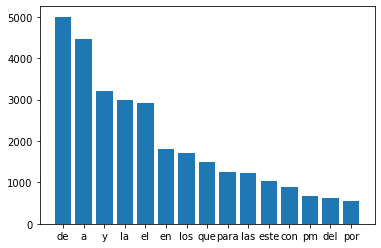

In [35]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y)

Top 15 Stopwords

# Most Frequent Words in the Dataset
***Top Non-Stopwords Barchart***

In [36]:
#Non Stopwords dictionary
dic2=defaultdict(int)
for word in lista:
    if word not in my_stop_words:
        dic2[word]+=1

<BarContainer object of 5 artists>

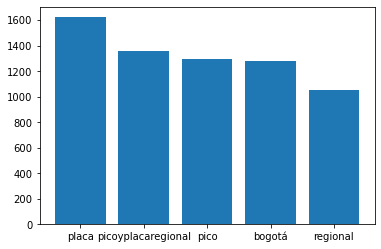

In [37]:
top2=sorted(dic2.items(), key=lambda x:x[1],reverse=True)[:5] 
x,y=zip(*top2)
plt.bar(x,y)

<AxesSubplot:>

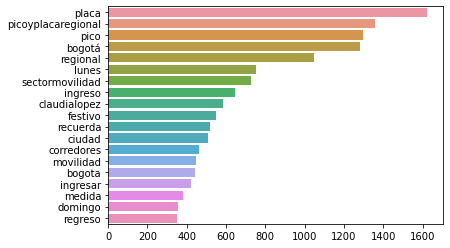

In [38]:
counter=Counter(lista)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in my_stop_words):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

# WordClouds

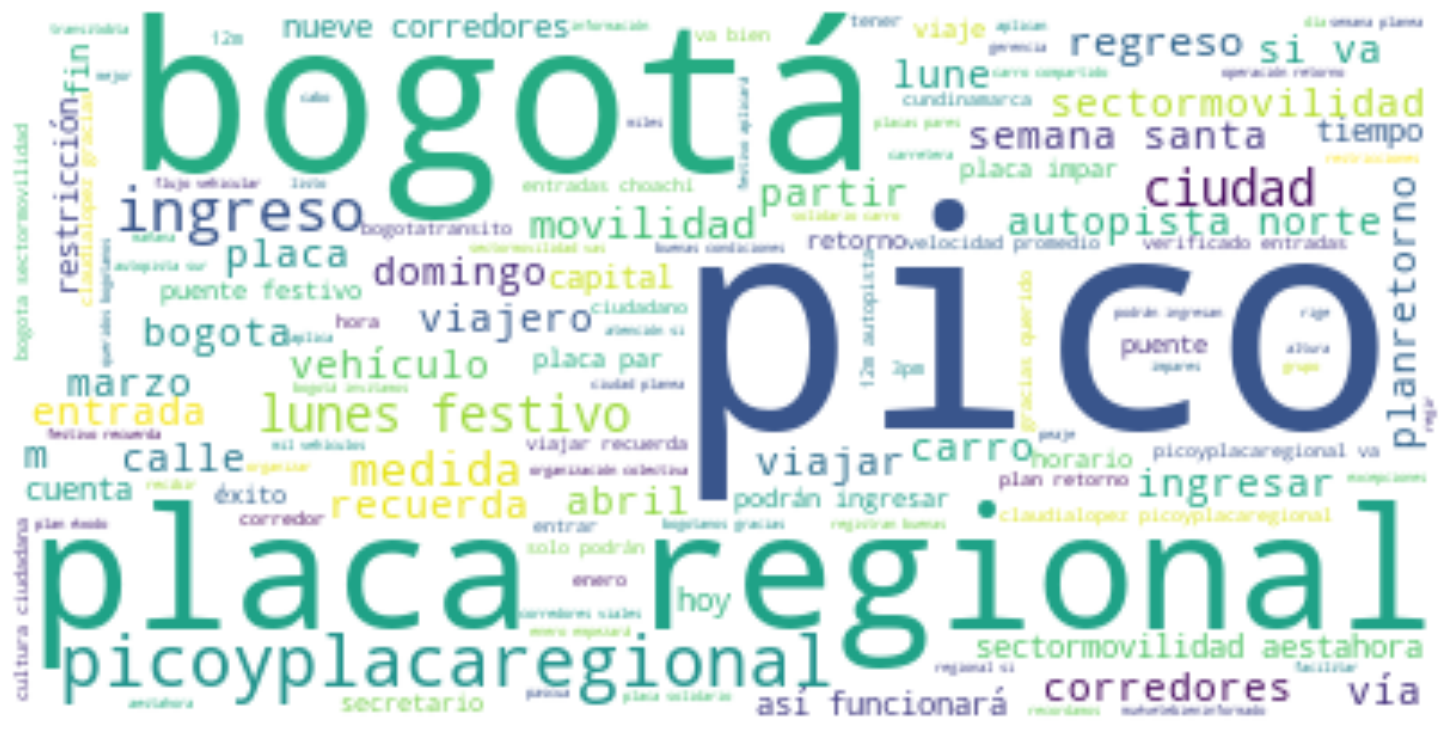

In [39]:

textcloud = " ".join(review for review in pyp.lower)

# Create and generate a word cloud image

mywordcloud = WordCloud(stopwords=my_stop_words, background_color="white", max_words=1000).generate(textcloud)
figure(figsize=(18.5, 10.5), dpi=100)
# Display the generated wordcloud image
plt.imshow(mywordcloud, interpolation='bilinear') 
plt.axis("off")
fig = plt.figure    
# Don't forget to show the final image
plt.show(fig)

# Ngrams

In [40]:
def get_top_ngram(lista, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(lista)
    bag_of_words = vec.transform(lista)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [41]:
top_bi_grams=get_top_ngram(pyp['lower'],n=2)
top_bi_grams

[('https tco', 1370),
 ('pico placa', 1338),
 ('placa regional', 1129),
 ('la ciudad', 593),
 ('este lunes', 547),
 ('el pico', 505),
 ('recuerda que', 451),
 ('de ingreso', 430),
 ('el picoyplacaregional', 420),
 ('en los', 403),
 ('lunes festivo', 392),
 ('corredores de', 388),
 ('de la', 385),
 ('ingreso la', 304),
 ('los corredores', 298),
 ('la medida', 293),
 ('habrá picoyplacaregional', 285),
 ('vas viajar', 275),
 ('de marzo', 256),
 ('para el', 253)]

In [42]:
top_tri_grams=get_top_ngram(pyp['lower'],n=3)
top_tri_grams

[('pico placa regional', 1108),
 ('el pico placa', 501),
 ('corredores de ingreso', 362),
 ('este lunes festivo', 331),
 ('los corredores de', 266),
 ('21 de marzo', 251),
 ('17 de abril', 204),
 ('placa regional para', 197),
 ('en los corredores', 193),
 ('ingreso la ciudad', 189),
 ('que este lunes', 183),
 ('del pico placa', 176),
 ('de pico placa', 168),
 ('de ingreso la', 167),
 ('recuerda que este', 167),
 ('de ingreso bogotá', 165),
 ('10 de enero', 156),
 ('si vas viajar', 155),
 ('domingo 17 de', 150),
 ('para ingresar la', 150)]

# Sentiment Analysis

In [44]:
from textblob import TextBlob
TextBlob('100 people killed in Iraq').sentiment.polarity

-0.2

In [45]:
TextBlob('100 personas asesinadas en Irak').translate(from_lang='es', to= 'en').sentiment.polarity

-0.2

In [46]:
def polarity(text):
    return TextBlob(text).translate(from_lang='es', to='en').sentiment.polarity


<AxesSubplot:>

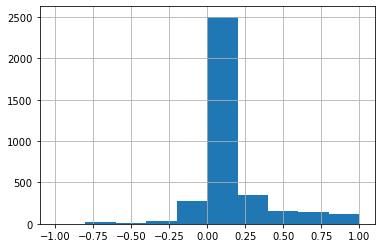

In [47]:
pyp['polarity_score']=pyp['lower'].apply(lambda x : polarity(x))
pyp['polarity_score'].hist()